# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls drive/MyDrive/Great_Learning/Project_3

'Mackall_James_A3 FULL CODE.ipynb'   ratings_Electronics.csv
 MLS_Yelp_Reviews_Notebook.ipynb     Recommendation_Systems_Learner_Notebook_Full_Code.ipynb


**Installing surprise library**

In [3]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [4]:
import surprise as sp

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [5]:
df = pd.read_csv('drive/MyDrive/Great_Learning/Project_3/ratings_Electronics.csv')

In [6]:
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
df.drop(columns = ['timestamp'], inplace = True)

In [7]:
df.head()

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [8]:
df_old = df.copy() # If we need the un-altered data later

In [9]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [10]:
# We want our users to have at least 50 ratings to be considered
MIN_RATINGS_USER = 50

remove_ids = []

for user, num_ratings in ratings_count.items():
    if num_ratings < MIN_RATINGS_USER:
        remove_ids.append(user)

df = df.loc[ ~ df.user_id.isin(remove_ids)]

In [11]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [12]:
# We want our item to have at least 5 ratings to be considered
MIN_RATINGS_PRODUCT = 5

remove_ids = []

for user, num_ratings in ratings_count.items():
    if num_ratings < MIN_RATINGS_PRODUCT:
        remove_ids.append(user)

df = df.loc[~ df.prod_id.isin(remove_ids)]

In [13]:
# Frequency conversion table to make it easier to interpret prod_id results
# Ex. if product B003ES5ZUU is getting reccomended often, we can look it up in
# the table to find out that it is the second most reviewed product

prod_id_to_freq = {}
prod_rating_count = df['prod_id'].value_counts()

for i, id in enumerate(prod_rating_count.index):
  prod_id_to_freq[id] = i
  #df.loc[df.prod_id == id, 'prod_id'] = 'P' + str(i)



# Same concept but for users

user_id_to_freq = {}
user_rating_count = df['user_id'].value_counts()

for i, id in enumerate(user_rating_count.index):
  user_id_to_freq[id] = i
  #df.loc[df.user_id == id, 'user_id'] = 'U' + str(i)

In [14]:
# Print a few rows of the imported dataset
df.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

**Check the number of rows and columns and provide observations.**

In [15]:
# Check the number of rows and columns and provide observations
df.shape

(65290, 3)

**Write your observations here:** The dataset appears to be of medium size. We have over 50,000 valid reviews.

### **Data types**

In [16]:
# Check Data types and provide observations
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Write your observations here:** Ratings are float even though they are only integer values. The other two columns are objects, or categorical, even though product ID seems to mostly contain integers.

### **Checking for missing values**

In [17]:
# Check for missing values present and provide observations
print(df.isnull().sum())
print()
print(df['rating'].value_counts())

user_id    0
prod_id    0
rating     0
dtype: int64

rating
5.0    36315
4.0    18127
3.0     6481
2.0     2515
1.0     1852
Name: count, dtype: int64


**Write your observations here:** No null values or invalid ratings

### **Summary Statistics**

In [18]:
df.rating = df.rating.astype(int)

In [19]:
# Summary statistics of 'rating' variable and provide observations
df['rating'].describe()

,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Write your observations here:** Most ratings are 5 star, which tends to be people's default.  There is a standard devation of almost 1 star and an average rating of about 4.3.

### **Checking the rating distribution**

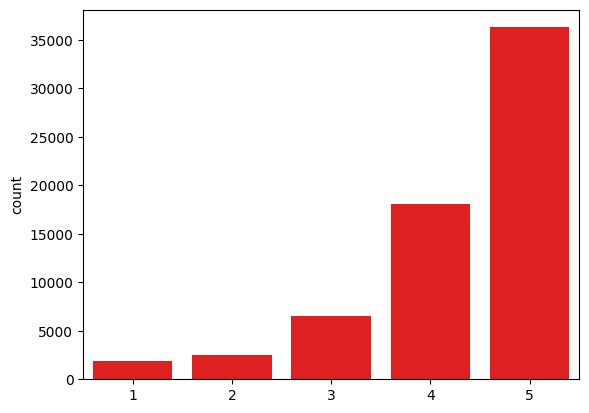

In [20]:
# Create the bar plot and provide observations
sns.barplot(y = df['rating'].value_counts(), x = [5,4,3,2,1], color = 'red')
plt.show()

**Write your observations here:** Similar to above. Lower ratings appear to be increasingly less frequent.

### **Checking the number of unique users and items in the dataset**

In [21]:
# Number of total rows in the data and number of unique user id and product id in the data
print('Unique users:')
print(df['user_id'].nunique())

print('Unique products:')
print(df['prod_id'].nunique())

Unique users:
1540
Unique products:
5689


**Write your observations here:** More unique products than users.

### **Users with the most number of ratings**

In [22]:
# Top 10 users based on the number of ratings
df['user_id'].value_counts()[:10]

,count
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
A680RUE1FDO8B,196
A1UQBFCERIP7VJ,193
A22CW0ZHY3NJH8,193
AWPODHOB4GFWL,184


**Write your observations here:** The user with the most ratings has almost 300, which is almost twice as much as the 10th place user.

### **User and product rating frequency distributions**

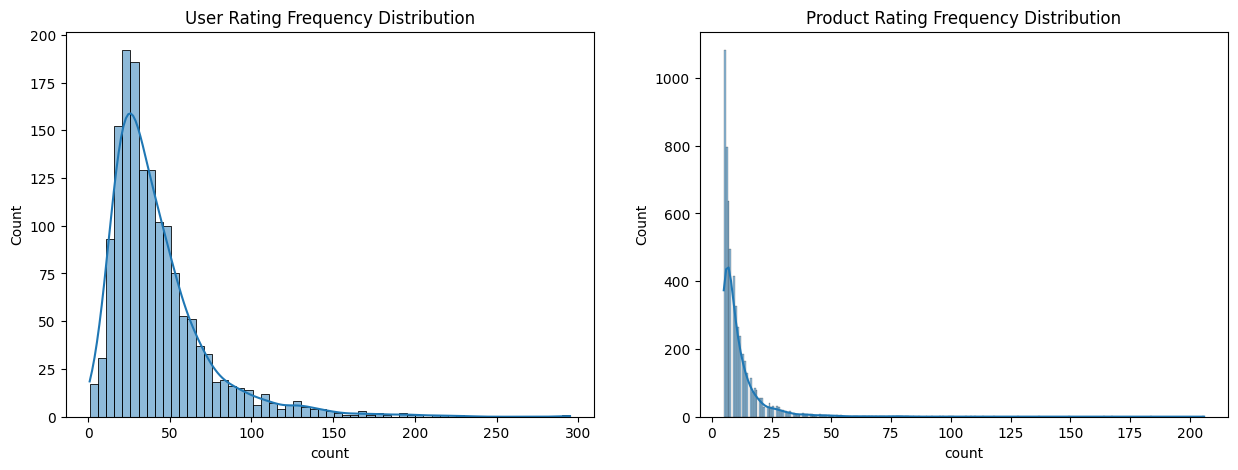

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

sns.histplot(df['user_id'].value_counts(), kde=True, ax=axes[0])
axes[0].set_title('User Rating Frequency Distribution')
sns.histplot(df['prod_id'].value_counts(), kde=True, ax=axes[1])
axes[1].set_title('Product Rating Frequency Distribution')

plt.show()

Both the product and user rating occurances appear to be heavily right skewed

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank-Based Recommendation System**

In [24]:
# Calculate the average rating for each product
avg_ratings = df.groupby('prod_id')['rating'].mean()#.sort_index()

# Calculate the count of ratings for each product
prod_rating_count = df['prod_id'].value_counts()

# Create a dataframe with calculated average and count of ratings
df_prod_ratings = pd.DataFrame({'rating_count': prod_rating_count, 'avg_rating': avg_ratings})

# Sort the dataframe by average of ratings in the descending order
df_prod_ratings.sort_values(by=['avg_rating', 'rating_count'], ascending=[False, False], inplace=True)

# See the first five records of the "final_rating" dataset
df_prod_ratings.head()

,rating_count,avg_rating
prod_id,,
B000FQ2JLW,19,5.0
B00ISFNSBW,18,5.0
B000IJY8DS,17,5.0
B001TH7GUA,17,5.0
B00HZWJGS8,17,5.0


In [25]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_with_m(df, minimum_interactions, n_returned):
    top_n = df[df['rating_count'] >= minimum_interactions].copy()
    top_n = top_n.sort_values(by=['avg_rating', 'rating_count'], ascending=[False, False])
    return top_n.head(n_returned)

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [26]:
top_n_with_m(df_prod_ratings, 50, 5)

,rating_count,avg_rating
prod_id,,
B001TH7GUU,78,4.871795
B003ES5ZUU,184,4.864130
B0019EHU8G,90,4.855556
B006W8U2MU,57,4.824561
B000QUUFRW,84,4.809524


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [27]:
top_n_with_m(df_prod_ratings, 100, 5)

,rating_count,avg_rating
prod_id,,
B003ES5ZUU,184,4.864130
B000N99BBC,167,4.772455
B002WE6D44,100,4.770000
B007WTAJTO,164,4.701220
B002V88HFE,106,4.698113


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [28]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing matrix factorization based recommendation system with alternating least squares
from surprise.prediction_algorithms.matrix_factorization import SVDpp

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [29]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [30]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0,5))

# Loading the rating dataset
d = Dataset.load_from_df(df, reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(d, test_size = 0.2, random_state = 1)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [31]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
KNN_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)


# Fit the model on the training data
KNN_user.fit(trainset)


# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(KNN_user)

RMSE: 1.0260
Precision:  0.844
Recall:  0.862
F_1 score:  0.853


**Write your observations here:** Precision and recall being right around 85% is a pretty good baseline.  RMSE is just over 1, meaning the model is averaging to just above 1 star off for each user's reccomended products.  This could easily be due to noise in the ratings, but it is likely we still have more room to optimize too.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [32]:
# Predicting rating for a sample user with an interacted product
KNN_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

**Write your observations here:** The predicted rating was 1.67 stars off. Not a great initial prediction.

'was_impossible': False means that this user was in the train set, and thus, the model has sufficient neighbors to predict an estimated rating for (it would otherwise use the global average if we ran this function on it).

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [33]:
# Find unique user_ids where prod_id is not equal to "1400501466"
unseen_users = list(df['user_id'].unique())
df_seen = df[df['prod_id'] == '1400501466']

for i, entry in df_seen.iterrows():
    unseen_users.remove(entry['user_id'])

print("A34BZM6S9L7QI4" in unseen_users)
len(unseen_users), df['user_id'].nunique(), df_seen['user_id'].nunique()

True


(1534, 1540, 6)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [34]:
# Predicting rating for a sample user with a non interacted product
KNN_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 1.99   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=1.991150442477876, details={'actual_k': 2, 'was_impossible': False})

**Write your observations here:** It is likely that this user would consider this product to be mediocre according to our model (because similar users thought this).  1.99 would be considered low because the average rating of all products (from our EDA) is 4.3

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [35]:
# Setting up parameter grid to tune the hyperparameters
# Pearson doesn't really apply here, so we will only look at cosine and msd
# I already did a pilot against the hyperparameters given, and found
# 'k': 50, 'min_k': 4, and 'name': 'cosine' to be best
# This is a more fine-tuned search
params = {'k': [40, 45, 50, 55, 60, 65, 70], 'min_k': [2, 3, 4, 5, 6],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, params, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(d)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9674320238698707
{'k': 70, 'min_k': 4, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [87]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
KNN_user_optimized = KNNBasic(sim_options = sim_options, k = 70, min_k = 4, random_state = 1, verbose = False)

# Training the algorithm on the trainset
KNN_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(KNN_user_optimized)

RMSE: 0.9751
Precision:  0.838
Recall:  0.892
F_1 score:  0.864


**Write your observations here:**

The optimized version had:
- RMSE: 0.9751
- Precision:  0.838
- Recall:  0.892
- F_1 score:  0.864

VS the non-optimized:
- RMSE: 1.0260
- Precision:  0.844
- Recall:  0.862
- F_1 score:  0.853


The precision scores are similar, but the recall is much better (3%) for the optimized version.  In my opinion, recall is the much more important metric here, because an Amazon user can simply scroll past an irrelevant item in less than a second (less precision = more irrelevant items, but the cost of irrelevant items is very low), but if a relevant, would-be-bought item is skipped over by the model, then Amazon is missing out on a potential sale.  On the other hand, it IS important that precision doesn't get horrible, or else users might get sick of sorting through muck and look elsewhere.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [88]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
KNN_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

In [89]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
KNN_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:** The predicted rating for the seen user was the same, but the rating for the unseen user was much higher.  This change is reflected in the higher recall score of the optimized, especially considering that this product would likely have gone from not-recommended to recommended.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [90]:
# 0 is the inner id of the above user
KNN_user_optimized.get_neighbors(0, 5)

[1, 10, 17, 18, 28]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [40]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [41]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df, "A3LDPF5FMB782Z", 5, KNN_user_optimized)

# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B00005LEN4,5
1,B00005U21H,5
2,B000067RT6,5
3,B00006B7DA,5
4,B00009R94Q,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [42]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
KNN_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the test set
KNN_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(KNN_item)

RMSE: 1.0147
Precision:  0.826
Recall:  0.853
F_1 score:  0.839


**Write your observations here:** The starting precision and recall are pretty similar at 83.5 and 84.5, respectively.  Also a pretty good starting point.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [43]:
# Predicting rating for a sample user with an interacted product
KNN_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.30   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.3, details={'actual_k': 20, 'was_impossible': False})

**Write your observations here:** More accurate than the unoptimized User-User system (and actually the same as the optimized one). Only 0.7 off and would have correctly reccomended the product.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [44]:
# Predicting rating for a sample user with a non interacted product
KNN_item.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.0, details={'actual_k': 4, 'was_impossible': False})

**Write your observations here:** More highly reccomended out of the gate than the User-User system.  Has a much more positive initial valence compared to un-optimized User-User's 1.99

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [45]:
# Setting up parameter grid to tune the hyperparameters
params = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
          'sim_options': {'name': ['msd', 'cosine'], 'user_based': [False]}}

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, params, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(d)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9757778489606327
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [84]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
KNN_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
KNN_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(KNN_item_optimized)

RMSE: 0.9751
Precision:  0.829
Recall:  0.892
F_1 score:  0.859


**Write your observations here:**

The scores for the optimized version were:
- RMSE: 0.9751
- Precision:  0.829
- Recall:  0.892
- F_1 score:  0.859

The scores for the non-optimized version were:
- RMSE: 1.0147
- Precision:  0.826
- Recall:  0.853
- F_1 score:  0.839

Yet again, the recall saw a significant bump from optimization, but the precision did not change much.  4% is a great increase though, especially considering the importance of high recall in this situation.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [85]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
KNN_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.62   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.617647058823531, details={'actual_k': 20, 'was_impossible': False})

In [86]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
KNN_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:** Upon optimization, the predicted rating has jumped up to 4.62, much like the optimized User-User model.  This is in line with the recall score increasing.  Same could be said with the unseen user's predicted rating increasing by 0.3 to 4.3.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [49]:
KNN_item_optimized.get_neighbors(0, k = 5)

[2, 4, 9, 12, 13]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [50]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df, "A1A5KUIIIHFF4U", 5, KNN_item_optimized)

# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.296427
1,1400599997,4.296427
2,9983891212,4.296427
3,B00000DM9W,4.296427
4,B00000J1V5,4.296427


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

## **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [51]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.9104
Precision:  0.837
Recall:  0.88
F_1 score:  0.858


**Write your observations here:** These starting precision and recall scores are the best yet.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [52]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.09   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.094312160755627, details={'was_impossible': False})

**Write your observations here:** This model gives a solid 4.09 to this user.  Higher than user-user but lower than item-item.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [53]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.05   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.051141373805704, details={'was_impossible': False})

**Write your observations here:** This prediction for the unseen predicted rating is the highest unoptimized value yet.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [54]:
# Set the parameter space to tune
# I already did a pilot run based on generally good parameters used in the Yelp
# Mentor case study, and I am expanding the search based on the values that were
# promising from the pilot round (20 epochs, lr_all = 0.01, reg_all = 0.2)
param_grid = {'n_epochs': [15, 20, 30], 'lr_all': [0.005, 0.01, 0.015],
              'reg_all': [0.1, 0.2, 0.3], 'n_factors': [50, 100, 150]}

# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(d)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8978717782574885
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2, 'n_factors': 100}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [81]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.2, n_factors = 100, random_state = 1)

# Train the algorithm on the trainset
svd_optimized = svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.9014
Precision:  0.841
Recall:  0.88
F_1 score:  0.86


**Write your observations here:**

The scores for the optimized version were:

- RMSE: 0.9014
- Precision:  0.841
- Recall:  0.88
- F_1 score:  0.86

The scores for the non-optimized version were:

- RMSE: 0.9104
- Precision:  0.837
- Recall:  0.88
- F_1 score:  0.858

In this case, the model must have been converging / performing pretty well to begin with, because the optimizations did not make a significant difference, particularly in crossing the 3.5 threshold value (looking at precision and recall).

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [82]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.09   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.090441179731308, details={'was_impossible': False})

In [83]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.06   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.06446285064312, details={'was_impossible': False})

The predicted ratings are pretty darn similar, reflecting the negligible change in performance metrics from non-optimized to optimized SVD models.

## **Model 4 (EXTRA): SVD Model with Alternative Least Squares**

In [69]:
# Using SVDpp algorithm with random_state 1
svdALS = SVDpp(random_state = 1)

# Training the algorithm on the trainset
svdALS.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svdALS)

RMSE: 0.9058
Precision:  0.841
Recall:  0.875
F_1 score:  0.858


In [70]:
# Set the parameter space to tune
# After a pilot run with a broader parameter space,
# 'n_epochs': 30, 'lr_all': 0.005, and 'reg_all': 0.2
# were found to be the best first guesses. This is a more fine-tuned check.
param_grid = {'n_epochs': [25, 30, 35], 'lr_all': [0.003, 0.005, 0.01],
              'reg_all': [0.15, 0.2, 0.3], 'n_factors': [50, 100]}

# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVDpp, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(d)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8989592567743988
{'n_epochs': 35, 'lr_all': 0.005, 'reg_all': 0.3, 'n_factors': 50}


In [76]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svdALS_optimized = SVDpp(n_epochs = 35, lr_all = 0.005, reg_all = 0.3, n_factors = 50, random_state = 1)

# Train the algorithm on the trainset
svdALS_optimized = svdALS_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svdALS_optimized)

RMSE: 0.9009
Precision:  0.839
Recall:  0.884
F_1 score:  0.861


Much like the other SVD model, there is little performance improvement from parameter optimization.  This model also took significantly longer to fit and check the parameter space of, so in this case, it seems to not be the optimal approach.

In [77]:
# Non-optimized prediction of known rating
svdALS.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.00   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.99556719057405, details={'was_impossible': False})

In [78]:
# Non-optimized prediction of unknown rating
svdALS.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.24   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.237256238425805, details={'was_impossible': False})

In [79]:
# Optimized svdALS prediction for known rating
svdALS_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.91   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.9139553285989797, details={'was_impossible': False})

In [80]:
# Optimized svdALS prediction for unknown rating
svdALS_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.09   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.09015533910804, details={'was_impossible': False})

The SVDpp also had relatively negligible change in results after optimization (which also took tremendously longer than any of the other algorithms).  Both opptimized prediction scores are actually lower, and perhaps the model has simply become slightly more conservative from optimization.

## **Model 5 (EXTRA): Cluster-Based Recommendation System**

In [58]:
# Using Co-Clustering algorithm
clusterer = CoClustering(random_state = 1)

# Training the algorithm on the train set
clusterer.fit(trainset)

# Let us compute precision@k and recall@k with k = 10
precision_recall_at_k(clusterer)

RMSE: 0.9563
Precision:  0.84
Recall:  0.824
F_1 score:  0.832


In [59]:
# Set the parameter space to tune
# After a pilot run with a broader parameter space,
# 'n_cltr_u': 3, 'n_cltr_i': 3, and 'n_epochs': 50
# were found to be the best first guesses. This is a more fine-tuned check.
param_grid = {'n_cltr_u': [2, 3, 4, 5], 'n_cltr_i': [2, 3, 4, 5], 'n_epochs': [30, 40, 50, 60]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(CoClustering, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(d)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9550817263640269
{'n_cltr_u': 2, 'n_cltr_i': 2, 'n_epochs': 60}


In [60]:
# Using tuned Coclustering algorithm
clusterer_optimized = CoClustering(n_cltr_u = 2, n_cltr_i = 2, n_epochs = 60, random_state = 1)

# Training the algorithm on the train set
clusterer_optimized.fit(trainset)

# Let us compute precision@k and recall@k with k = 10
precision_recall_at_k(clusterer_optimized)

RMSE: 0.9438
Precision:  0.841
Recall:  0.831
F_1 score:  0.836


Performance metrics of the clustering algorithm do not seem to improve much with optimization.

In [61]:
# Making prediction for user_id 4 and business_id 9483
clusterer.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.55   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.5486097929700495, details={'was_impossible': False})

In [62]:
# Making prediction for userid 4 and business_id 9980
clusterer.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 3.74   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=3.7449979604327055, details={'was_impossible': False})

In [63]:
# Making prediction for user_id 4 and business_id 9483
clusterer_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.52   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.5242089195107935, details={'was_impossible': False})

In [64]:
# Making prediction for userid 4 and business_id 9980
clusterer_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 3.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=3.399062122304204, details={'was_impossible': False})

The lack of performance metric improvement can be seen by how little the predicted ratings change.  Furthermore, these ratings are the least accurate of any of the models that we have tested.

This reflects the deeper purpose of clustering algorithms being simply for grouping.  In the case where we have one ordinal feature (1-5) with which to separate clusters from, it makes sense that there would not be much predictive or recommending capabilities gained by trying to separate the data.  It is likely that without more features, clustering would continue to underperform compared the other models we have tried.

## **Recommendation System Comparison and Performance**

The final results of each tuned model are listed below.

User-User:

- RMSE: 0.9751
- Precision:  0.838
- Recall:  0.892
- F_1 score:  0.864


Item-Item:

- RMSE: 0.9751
- Precision:  0.829
- Recall:  0.892
- F_1 score:  0.859


SVD:

- RMSE: 0.9014
- Precision:  0.841
- Recall:  0.88
- F_1 score:  0.86


SVDpp:

- RMSE: 0.9009
- Precision:  0.839
- Recall:  0.884
- F_1 score:  0.861


Cluster-Based:

- RMSE: 0.9438
- Precision:  0.841
- Recall:  0.831
- F_1 score:  0.836

Overall, SVD and SVDpp performed much better than the other models in terms of RMSE, meaning their predicted ratings of the test set users were the closest to their actual values.  On the other hand, the F_1 score of all of the models (besides clustering) was pretty similar, meaning that most of the time, the models were evenly matched at predicting whether a user's rating would be above or below 3.5.  In the context of producing reccomendations for users on Amazon, the similar F_1 scores indicate that all of the model types can still produce helpful reccomendations.  But if it comes to predicting how well a product will be recieved by a user, SVD and SVDpp seem like the best options.  Unsurprisingly, the cluster-based reccomendation system performed the worst overall, but this is expected because the purpose of this method as it applies to our data is really just to reccomend items to users based on similar groups, and not necessarily to get especially accurate predictions.

Going forward for this final set of recommendations, we will use SVD. It and SVDpp were the most accurate models, but SVD took significantly shorter to train over SVDpp.  In practice, SVD would likely be the better choice due to Amazon's massive size and amount of data that it has to process, and would serve better as a model that can run and update on the fly as users provide new usage data.

### **Ranking Product Comparison**

In the MLS_Yelp case study, the point that product popularity (and likelihood of user purchase) is not solely related to average rating was brought up.  The general implication of this towards our dataset is that more reviewed (and thus, purchased) products should be given more value than less reviewed products, considering that more people buy them at the end of the day.

The case study states that the empirical value corresponding to likelihood of positive product reception corresponds with 1 / sqrt(rating_count), which we can leverage to find a more realistic prediction of reccomended products as a post-processing step.  That is, when choosing which products to reccomend, we can assign a penalty to under-reviewed products with this formula, giving a more distinct ranking system (and prioritizing, say, a 5 star product with 50 reviews over a 5 star product with 2 reviews).

In [65]:
product_counts = df['prod_id'].value_counts()

def ranking_product(reccomendations, top_n):
    r = pd.DataFrame(reccomendations, columns = ['id', 'predicted_rating'])
    r.insert(2, 'adjusted_rating', 0.0)
    r.insert(1, 'product_frequency_rank', -1)
    for id, predicted in reccomendations:
        freq = product_counts.loc[id]
        r_product = predicted - 1 / np.sqrt(freq)
        r.loc[r['id'] == id, 'adjusted_rating'] = r_product
        r.loc[r['id'] == id, 'product_frequency_rank'] = prod_id_to_freq[id] + 1
    r.sort_values(by = 'adjusted_rating', ascending = False, inplace = True)
    return r.head(top_n)

### **Final reccomendation product**

Aside from RMSE, the user-user collaborative filtering model appeared to have the best metrics, especially when prioritizing recall.  If we were seeking to minimize RMSE (or essentially get the closest possible predicted star ratings), The SVD model seems to be the best bet.  But considering the increased computational cost of optimizing SVD and the slightly worse recall score (and F1), **we will go with the user-user collaborative filtering method to demonstraTE our final prediction model**.  In practice, however, we / Amazon could practice hybrid reccomendation by displaying each type of model in a different feed (such as "other users liked", "similar items to what you looked at", "products we think you will like", etc).

To demonstrate the user-user model's functionality, we will apply the ranking product to the get reccomendations function , then return the top k most relevant product ID's along with their overall product frequency ranking, their predicted rating, and their corrected rating (which is what is being used to score top reccomendations from bottom).

In [66]:
# Reminding how many different users and products are in the dataset
df['user_id'].nunique(), df['prod_id'].nunique()

(1540, 5689)

In [67]:
# Finding ids with varying amounts of ratings given to the dataset
ids_to_check = [key for key, value in user_id_to_freq.items() if value in [0, 9, 99, 999]]
ids_to_check

['ADLVFFE4VBT8', 'AGVWTYW0ULXHT', 'A3R1WFO4KIUQXZ', 'A2L90SGUP36KGA']

In [68]:
# get_recommendations(data, user_id, top_n, algo)
recs_1 = get_recommendations(df, 'ADLVFFE4VBT8', 50, svd_optimized)
recs_2 = get_recommendations(df, 'AGVWTYW0ULXHT', 50, svd_optimized)
recs_3 = get_recommendations(df, 'A3R1WFO4KIUQXZ', 50, svd_optimized)
recs_4 = get_recommendations(df, 'A2L90SGUP36KGA', 50, svd_optimized)

final_recs_1 = ranking_product(recs_1, 10)
final_recs_2 = ranking_product(recs_2, 10)
final_recs_3 = ranking_product(recs_3, 10)
final_recs_4 = ranking_product(recs_4, 10)

print("Final top 10 recommendations for 1st most reviewing user.")
display(final_recs_1)
print()
print("Final top 10 recommendations for 10th most reviewing user.")
display(final_recs_2)
print()
print("Final top 10 recommendations for 100th most reviewing user.")
display(final_recs_3)
print()
print("Final top 10 recommendations for 1000th most reviewing user.")
display(final_recs_4)

Final top 10 recommendations for 1st most reviewing user.


,id,product_frequency_rank,predicted_rating,adjusted_rating
15,B0052SCU8U,79,4.811085,4.668228
8,B001QUA6RA,229,4.831541,4.651936
20,B00BQ4F9ZA,103,4.799310,4.650239
2,B00FR6VL50,760,4.865930,4.630228
28,B008EQZ25K,147,4.790271,4.628049
32,B001TH7T2U,133,4.784405,4.626291
16,B004ELA0SS,286,4.806270,4.617288
22,B001UI2FPE,250,4.796490,4.613916
1,B00889ST2G,1328,4.888653,4.611303
3,B0010Z28XG,975,4.864885,4.606686



Final top 10 recommendations for 10th most reviewing user.


,id,product_frequency_rank,predicted_rating,adjusted_rating
15,B0052SCU8U,79,4.609656,4.466799
11,B001UI2FPE,250,4.622408,4.439834
1,B00FR6VL50,760,4.673331,4.437629
13,B001QUA6RA,229,4.615565,4.435959
40,B00BQ4F9ZA,103,4.581348,4.432277
2,B002NO7PWC,712,4.666361,4.430659
25,B008EQZ25K,147,4.592471,4.430249
42,B001TH7T2U,133,4.580027,4.421914
18,B004ELA0SS,286,4.605301,4.416319
24,B005ES0YYA,354,4.593007,4.396891



Final top 10 recommendations for 100th most reviewing user.


,id,product_frequency_rank,predicted_rating,adjusted_rating
19,B0052SCU8U,79,4.821630,4.678773
14,B001QUA6RA,229,4.832540,4.652934
3,B00FR6VL50,760,4.887893,4.652190
4,B002NO7PWC,712,4.880886,4.645184
45,B00BQ4F9ZA,103,4.788007,4.638936
20,B004ELA0SS,286,4.819246,4.630264
24,B005ES0YYA,354,4.811058,4.614942
21,B00COF7DGS,460,4.817738,4.609224
0,B000JV9LUK,1987,4.912009,4.595781
28,B007PJ4P4G,478,4.806594,4.593394



Final top 10 recommendations for 1000th most reviewing user.


,id,product_frequency_rank,predicted_rating,adjusted_rating
35,B0052SCU8U,79,4.809299,4.666442
13,B001UI2FPE,250,4.844826,4.662251
38,B00BQ4F9ZA,103,4.802730,4.653659
2,B002NO7PWC,712,4.887766,4.652063
5,B00FR6VL50,760,4.878406,4.642703
25,B004ELA0SS,286,4.824141,4.635159
37,B001QUA6RA,229,4.806727,4.627122
34,B00081A2KY,345,4.812632,4.616516
0,B000JV9LUK,1987,4.925797,4.609569
4,B000BYCKU8,1255,4.881566,4.604216


It can be seen that the ranking product makes a significant difference in which products are prioritized in recommendations to different users.  It can also be seen that certain products are preffered by the model to recommend, likely because they have gotten very high average ratings from the users that reviewed them.  Included in this are the 78th most reviewed product, the 228th, and the 102nd.

Product review frequency doesn't inherently appear to be affecting the model's recommendations, or else we would see more in the 1-100 range of frequency rank.  Instead, the ranking product allows for a gentle introduction of popularity weighting into the reccomendation process by providing a good tie-breaker for predicted rankings which are otherwise very close in value.

## **Conclusion and Recommendations**

### **Final Takeaways**

**Write your conclusion and recommendations here**

**Conclusions:**

- The SVD models were best at most closely predicting star ratings, while the user-user and item-item models were best at finding products that a user might like (highest recall).  The collaborative filtering models also took significantly shorter to optimize than the SVD models.

- Clustering did not perform well with this dataset, likely because there weren't enough variables to find specific clusters with.

- Balancing ranking predictions with a ranking product, which in this case we based on product popularity, allows for a way to discern between otherwise similarly rated predictions and choose the product most likely to be selected.

- The SVD model, and likely the other ones as well, had some clear favorite products.  It is likely that these products were simply the highest rated in the dataset, and with no other features or selection criteria other than rating, this is bound to happen.

**Recommendations:**

- It would be worthwhile for Amazon to consider recording when products are purchased but not rated.  This could be a potential relevant indicator in the quality of a product, considering that no review likely means the product was not good or bad enough to warrent the user leaving said review.

- Clustering might be a method worth implementing if there are more categories within the data, but in the case of one ordinal variable such as rating, it does not provide much utility aside from another way to generate reccomendations.

- Overall, the more data Amazon can collect on users and products in addition to ratings, the more specific the recommendation systems can get.  These results are already pretty good for only having one variable to work with, with every model producing a RMSE of less than 1 (and thus, being on average, less than one star off).  If there were more features, such as category of product, user's recently shopped categories, product brand, etc, it is likely that rating predictions would experience less RMSE, have more personalization towards users, and more variety between products recommended.

- If Amazon were to implement these recommendation systems, they would benefit from a hybrid approach.  While the User-User collaborative filtering model might capture some similaries in products two users might like, they can't specifically look for similar items like Item-Item filtering does.  And neither are as accurate as SVD.  Amazon does not know what the user is looking for every time the go on the website.  However, if they show multiple feeds of different types of product recommendations, it is likely that between the different models, the user will see something they like and will hopefully purchase.